# Introduction
This python notebook will be used for testing out the NZN parameter sets

## Importing functions and parameter sets

In [1]:
from besos.parameters import wwr, RangeParameter, FieldSelector, FilterSelector, GenericSelector, Parameter, expand_plist
from besos.parameters import RangeParameter, CategoryParameter, expand_plist

from besos import eppy_funcs as ef
import besos.sampling as sampling
from besos.evaluator import EvaluatorEP
from besos.problem import EPProblem

import copy
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt

In [2]:
import os
import sys

#importing a pre-existing parameter set database
nzn_pathway='./parameter_set'
sys.path.append(nzn_pathway)

from architectural_parameters import architectural_parameters
# from comfort_parameters import comfort_parameters
from envelope_parameters import envelope_parameters
# from lighting_parameters import lighting_parameters
# from loads_parameters import loads_parameters
# from plant_parameters import heating_plant_parameters
# from plant_parameters import cooling_plant_parameters
# from renewable_parameters import renewable_parameters
# from system_parameters import system_parameters
# from system_parameters import FCU_parameters
# from system_parameters import VAV_parameters
# from system_parameters import CB_parameters

In [3]:
parameters=[]
defaults={}
inputs_metadata=[]

parameter_sets=[architectural_parameters,envelope_parameters]

for i in parameter_sets:
    parameters.extend(i()[0])
    defaults.update(i()[1])
    inputs_metadata.extend(i()[2])

/home/user/.local/lib/python3.7/site-packages/besos/parameters.py:425: FutureWarning: Use value_descriptors instead of value_descriptor.
  FutureWarning("Use value_descriptors instead of value_descriptor.")


In [4]:
# inputs_metadata

In [5]:
import NZN_output_set
from NZN_output_set import fuel_use
from NZN_output_set import end_use_breakdown
from NZN_output_set import metrics

In [6]:
outputs, outputs_metadata = fuel_use()
outputs1, outputs_metadata1 = end_use_breakdown()
outputs2, outputs_metadata2 = metrics()

outputs = outputs+outputs1+outputs2
outputs_metadata = outputs_metadata+outputs_metadata1+outputs_metadata2

In [7]:
len(outputs_metadata)

24

In [8]:
# Drop any metadata associated with dropped outputs (reference Sampling notebook to confirm which outputs to drop - they must match)

def remove_output_metadata(removed_output_metadata_list, output_metadata_list):
    for label in removed_output_metadata_list:
        for metadata in output_metadata_list:
            if metadata['Label'] == ("{} (ekWh/m2)".format(label)):
                print(label)
                output_metadata_list.remove(metadata)
            
    return output_metadata_list

Manually edit 'removed_output_metadata_list' to include all ouput metadata that should not be included.

In [9]:
removed_output_metadata_list = ['Gas:Facility','Heating:Electricity','Heating:Gas','Cooling:Electricity','ExteriorLights:Electricity', 
                        'InteriorEquipment:Gas', 'ExteriorEquipment:Electricity', 'ExteriorEquipment:Gas', 
                        'Fans:Electricity', 'Pumps:Electricity', 'HeatRejection:Electricity', 'Humidifier:Electricity', 'Humidifier:Gas', 
                        'WaterSystems:Electricity', 'WaterSystems:Gas', 'TED']
outputs_metadata = remove_output_metadata(removed_output_metadata_list, outputs_metadata)

Gas:Facility
Heating:Electricity
Heating:Gas
Cooling:Electricity
ExteriorLights:Electricity
InteriorEquipment:Gas
ExteriorEquipment:Electricity
ExteriorEquipment:Gas
Fans:Electricity
Pumps:Electricity
HeatRejection:Electricity
Humidifier:Electricity
Humidifier:Gas
WaterSystems:Electricity
WaterSystems:Gas
TED


In [10]:
len(outputs_metadata)

8

In [11]:
# Import the pickled inputs and results from Sampling Notebook
inputs = pd.read_pickle('overall_inputs.p')
results_EUI = pd.read_pickle('overall_results.p')

# Building Specific Metadata

In [12]:
default_building = ef.get_building('NZN_Secondary_School_Default.idf')

In [13]:
# Get approximate floor area of building
def get_floor_area(model):
    prev_area = 0
    for surface in model.idfobjects['BUILDINGSURFACE:DETAILED']:
        if surface['Surface_Type'] == 'Floor':
            area = surface.area
            total_area = area + prev_area
            prev_area = total_area
    est_floor_area = (str(round(total_area)) + ' m2')
    return(est_floor_area)

est_floor_area = get_floor_area(default_building)
print(est_floor_area)

19592.0 m2


In [14]:
print(default_building.idfobjects['BUILDING'][0].Name)   # Use this to double check building type against model
print(default_building.idfobjects['SITE:LOCATION'][0].Name)  # Use this to double check building location against model

NZN_Secondary_School
Victoria Int'l


In [15]:
# Reference picture of model
from IPython.display import Image
photo = Image("thumbnail.png")
# photo

Enter in building description here:

In [16]:
building_description = """"This is 2 story typical secondary school. Each story is 4 m tall, has no doors modelled,
and has a consistent window along the entire perimeter of each story. Additionally, there are 90 skylights on top of 
the gym and auxillary gym. The "main" part of the building includes the library, auditorium, gym & auxillary gym, 
cafeteria, kitchen, offices, bathrooms, lobby, and mechanical rooms, each with it's own spacetype. The gym & auxillary 
gym and the auditorium are both two stories high. Other spaces like the bathrooms, mechanical rooms, offices, and 
lobbies have been doubled up, with a different thermal zone for each on each floor. There is a main corridor running through the main part of the 
building on each floor, and other corridors extending through each of the building's "arms" on each floor. All of the 
classrooms are in these arms. One of the arms also contains two computer rooms which have their own spacetype."""

Define building metadata in dictionary below. Fields can all be entered manually if desired.

In [17]:
model_attributes = {
    "Building Type" : "Secondary School",
    "Location" : "Victoria, BC",
    "Estimated Floor Area" : est_floor_area,
    "Photo" : photo,
    "Description": building_description
    }

In [18]:
# model_attributes

# Surrogate Model
A surrogate model will be used to speed up the analysis process. After the initial sampling, the surrogate will be used to do a massive re-sampling to feed into our statistics.

The general steps to create a surrogate model are:
- Create the general architecture
- Identify hyper-parameters
- Normalize the inputs
- Normalize the outputs
- Split to training & testing set
- Train the ML model
- Validate

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LeakyReLU


Couldn't import dot_parser, loading of dot files will not be possible.


## One Hot Encoding
We need to convert our categorical values in one-hot encoded columns for non-ordinal ML training.

In [20]:
inputs_onehot=pd.get_dummies(inputs)
inputs_onehot

North Window to Wall Ratio (%)  East Window to Wall Ratio (%)  \
0                         0.333683                       0.896635   
1                         0.950263                       0.242801   
2                         0.137251                       0.062084   
3                         0.399515                       0.445806   
4                         0.823643                       0.713273   
5                         0.067810                       0.648900   
6                         0.899358                       0.747014   
7                         0.282642                       0.027592   
8                         0.660493                       0.592554   
9                         0.164705                       0.129167   
10                        0.760657                       0.974766   
11                        0.030754                       0.260043   
12                        0.586076                       0.185280   
13                        0.486027                       0.797684   
14                        0.348597                       0.505477   
15                        0.211567                       0.629540   
16                        0.501549                       0.337420   
17                        0.857928                       0.370773   
18                        0.705669                       0.488635   
19                        0.623445                       0.868092   

    South Window to Wall Ratio (%)  West Window to Wall Ratio (%)  \
0                         0.115197                       0.893500   
1                         0.358272                       0.617900   
2                         0.722705                       0.169714   
3                         0.746009                       0.542449   
4                         0.831927                       0.957794   
5                         0.300686                       0.049634   
6                         0.913860                       0.336138   
7                         0.690226                       0.663151   
8                         0.432652                       0.419609   
9                         0.953765                       0.697820   
10                        0.085310                       0.582960   
11                        0.169061                       0.888195   
12                        0.482592                       0.839318   
13                        0.010551                       0.116761   
14                        0.200702                       0.234582   
15                        0.601993                       0.274321   
16                        0.509372                       0.771853   
17                        0.856899                       0.474174   
18                        0.556955                       0.353890   
19                        0.250432                       0.096305   

    North Shading (m)  East Shading (m)  South Shading (m)  West Shading (m)  \
0            1.424905          0.441944           1.161408          0.710333   
1            0.042786          0.930805           1.803600          0.589165   
2            0.369037          1.072683           1.420576          0.301651   
3            1.892691          1.109440           0.462486          0.600814   
4            1.987957          1.878557           0.875330          0.134797   
5            1.715975          0.523166           0.365117          1.073857   
6            0.859610          0.836514           0.643853          0.999063   
7            0.607630          0.001276           1.087014          0.050587   
8            0.437080          1.461263           1.320505          0.888886   
9            0.104892          1.796145           1.996369          1.169620   
10           1.582011          0.759116           0.734473          1.712241   
11           1.375327          0.640145           0.084860          1.905587   
12           0.775113          0.176845           0.976260      

## Train-Test Split
We'll do 80/20 train/test split here

In [21]:
train_in, test_in, train_out, test_out = train_test_split(inputs_onehot, results_EUI, test_size=0.2)

## Normalization of inputs

To ensure an equal weighting of inputs and outputs in the backpropagation algorithm fitting the neural network, we have to normalize the input values.   
Different options for normalization exist.  
Here we bring all features (input variables) to have zero mean and a standarddeviation of 1.  
Note that we fit the normalizer on training data only.

In [22]:
scaler_in = StandardScaler()
NN_inputs = scaler_in.fit_transform(X=train_in)
NN_inputs_test=scaler_in.transform(X=test_in)

scaler_out = StandardScaler()
NN_outputs = scaler_out.fit_transform(X=train_out+0.00001)
NN_outputs_test=scaler_out.transform(X=test_out+0.00001)

In [23]:
# NN_outputs

## Build the Model
Using the keras functional API, we will build a relatively simple deep neural network

In [24]:
#This matches the number of parameter inputs we have to enter as the input layer into the NN
num_inputs = len(inputs_onehot.columns)
print(f'Number of inputs: {num_inputs}')
#This matches the number of model outputs we have to enter as the output layer into the NN
num_outputs = len(results_EUI.columns)
print(f'Number of inputs: {num_outputs}')

Number of inputs: 19
Number of inputs: 8


In [25]:
results_EUI

Electricity:Facility  DistrictHeating:Facility  DistrictCooling:Facility  \
0              41.287442                 35.886677                 14.929479   
1              36.913674                 94.023696                 19.508357   
2              39.229076                120.639221                 12.603068   
3              38.443509                 58.460735                 11.037754   
4              35.672874                162.014956                 18.420822   
5              39.425760                 89.592655                 14.414243   
6              36.321573                 75.086544                 20.077052   
7              37.255039                 50.475000                  8.986301   
8              36.364762                 81.799879                 18.240373   
9              37.263846                 88.391556                 16.589699   
10             40.453674                 50.639439                 13.753341   
11             40.606235                106.782109                 11.877697   
12             36.122616                163.609876                 12.981403   
13             40.901562                 37.321218                 16.925050   
14             38.920745                171.241404                 13.829555   
15             37.656630                 48.671459                 14.765914   
16             35.851692                221.323053                 14.075909   
17             37.981758                 54.935570                 28.492789   
18             36.071618                 69.052110                 21.884395   
19             37.765583                 45.503636                 15.895938   

    Heating:DistrictHeating  Cooling:DistrictCooling  \
0                 35.886677                14.929479   
1                 94.023696                19.508357   
2                120.639221                12.603068   
3                 58.460735                11.037754   
4                162.014956                18.420822   
5                 89.592655                14.414243   
6                 75.086544                20.077052   
7                 50.475000                 8.986301   
8                 81.799879                18.240373   
9                 88.391556                16.589699   
10                50.639439                13.753341   
11               106.782109                11.877697   
12               163.609876                12.981403   
13                37.321218                16.925050   
14               171.241404                13.829555   
15                48.671459                14.765914   
16               221.323053                14.075909   
17                54.935570                28.492789   
18                69.052110                21.884395   
19                45.503636                15.895938   

    InteriorLights:Electricity  InteriorEquipment:Electricity         TEU  
0                    24.060064                      17.227378   92.103598  
1                    19.686296                      17.227378  150.445727  
2                    22.001697                      17.227378  172.471364  
3                    21.216130                      17.227378  107.941997  
4                    18.445496                      17.227378  216.108653  
5                    22.198381                      17.227378  143.432657  
6                    19.094195                      17.227378  131.485169  
7                    20.027661                      17.227378   96.716340  
8                    19.137384                      17.227378  136.405015  
9                    20.036468                      17.227378  142.245100  
10                   23.226296                      17.227378  104.846453  
11                   23.378856                      17.227378  159.266040  
12                   18.895238                      17.227378  212.713895  
13                   23.674184                      17.227378   95.147830  
14    

In [26]:
#Create a 4-layer model, with 2 middle layers both with nodes that are 16*the number of inputs
#The hidden layers are activated with ReLU function.
# Since we are performing regression we do not want an activation for the output. 
#The output has been normalized to 0 +/- 1 std, and a ReLU activation function only returns positive numbers.
#We will use an L2 regularizer to help prevent overfitting. For now we will use the default alpha 0.01.

input_layer = keras.Input(shape=(num_inputs,))

#first hidden layer
dense_1 = layers.Dense(units=num_inputs*5, kernel_regularizer='l1_l2')(input_layer)
activation_1=layers.LeakyReLU()(dense_1)
#second hidden layer
dense_2 = layers.Dense(units=num_inputs*5, kernel_regularizer='l1_l2')(activation_1)
activation_2=layers.LeakyReLU()(dense_2)
#third hidden layer
dense_3 = layers.Dense(units=num_inputs*5, kernel_regularizer='l1_l2')(activation_2)
activation_3=layers.LeakyReLU()(dense_3)


#output layer
output_layer = layers.Dense(units=num_outputs)(activation_3)

model=models.Model(inputs=input_layer,outputs=output_layer)

In [27]:
print(model.summary())
# plot_model(model)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
dense (Dense)                (None, 95)                1900      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 95)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 95)                9120      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 95)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 95)                9120      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 95)               

## Hyper-parameters

Before we start fitting the NN model we define the set of hyperparameters we want to analyse in our cross-validation to optimize the model.  
Here, we select the number of layers of the network as well as the regularization parameter alpha as parameter value.  
A larger number of layers and a lower value of the regularizer lead to higher variance of the network.  
This may lead to overfitting.  
The best selection may be found using an optimizer like Bayesian Optimization.  
In this example we use a simple grid search.

## Training

Here we will compile and train the model.

In [28]:
loss = 'mean_squared_error'
optimizer = 'adam'
metrics=['mae', 'mse']

model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

In [29]:
history=model.fit( x=NN_inputs, y=NN_outputs, batch_size = 256,epochs=1000)
test_scores = model.evaluate(NN_inputs_test, NN_outputs_test, verbose=2)
print("Test MAE:", test_scores[0])
print("Test MSE:", test_scores[1])

Epoch 1/1000
1/1 [==============================] - 0s 2ms/step - loss: 21.4154 - mae: 0.8945 - mse: 1.1324
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 21.1498 - mae: 0.8691 - mse: 1.0772
Epoch 3/1000
1/1 [==============================] - 0s 1ms/step - loss: 20.8903 - mae: 0.8458 - mse: 1.0283
Epoch 4/1000
1/1 [==============================] - 0s 1ms/step - loss: 20.6369 - mae: 0.8243 - mse: 0.9853
Epoch 5/1000
1/1 [==============================] - 0s 1ms/step - loss: 20.3884 - mae: 0.8048 - mse: 0.9472
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - loss: 20.1441 - mae: 0.7868 - mse: 0.9128
Epoch 7/1000
1/1 [==============================] - 0s 995us/step - loss: 19.9035 - mae: 0.7705 - mse: 0.8816
Epoch 8/1000
1/1 [==============================] - 0s 1ms/step - loss: 19.6665 - mae: 0.7555 - mse: 0.8532
Epoch 9/1000
1/1 [==============================] - 0s 937us/step - loss: 19.4329 - mae: 0.7415 - mse: 0.8275
Epoch 10/1000
1/1 [=====

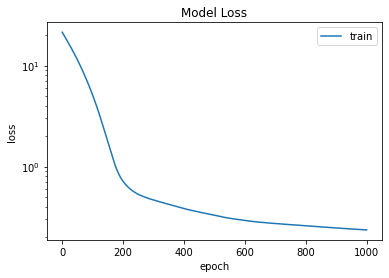

In [30]:
fig = plt.figure()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

## Evaluate test set
Evaluate the test set using the NN and the actual values

In [31]:
test_eval=model(NN_inputs_test,training=False)
test_eval=scaler_out.inverse_transform(test_eval)
test_eval_df=pd.DataFrame(test_eval,columns=results_EUI.columns)

In [32]:
# test_eval_df
# test_out

## Visually Compare the test dataset

In [33]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

In [35]:
mask = test_eval_df.isnull().values.sum(axis=1)==1
print(mask.sum())

0


In [36]:
_=[plt.plot(test_out.iloc[:,i], test_eval_df.iloc[:,i],'x') for i in range(num_outputs)]
print()

In [37]:
outputs=results_EUI.columns

plt.bar(range(0,len(outputs)*2,2),r2_score(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'))
plt.ylim([-1,1.05])
ax = plt.gca()
ax2=ax.twinx()

ax2.bar(range(1,len(outputs)*2,2),
        mean_absolute_error(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'),
       color='orange')

ax.set_xticks(range(1,len(outputs)*2,2))
_=ax.set_xticklabels(outputs, rotation=90)
ax.set_ylabel('R2-score')
ax2.set_ylabel('MAE [eKWh]')
plt.grid=False
print(r2_score(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'))
print()

[  0.35225206   0.72904375 -15.51136687   0.73259462 -15.42223158
   0.3339477    0.           0.65643481]



In [38]:
results_EUI.columns
end_uses=results_EUI.columns[2:-2]

This plotly chart is an interactive chart that will show the end-use breakdown in bar charts. It compares the results of a NN and the original E+ simulations.

In [39]:
# traces=[]
# buttons=[dict(label = "All",
#                  method = "update",
#                  args = [{"visible": True}])]

# for row in test_eval_df.index.to_list():
#     visibles=[False]*len(test_eval_df.index)
#     visibles[row]=True
    
#     traces.append(
#         go.Bar(
#             x = end_uses,
#             y = test_eval_df.iloc[row][end_uses],
#             name = (f"NN: {row}"),
#             yaxis="y2"
#         ))
    
#     buttons.append(
#     dict(label = str(row),
#                  method = "update",
#                  args = [{"visible": visibles}])
#     )
    
# for row in test_eval_df.index.to_list():
   
#     traces.append(
#         go.Bar(
#             x = end_uses,
#             y = test_out.iloc[row][end_uses],
#             name = (f"E+: {row}"),
#             yaxis="y2"
            
#         ))   
    
# for row in test_eval_df.index.to_list():
   
#     traces.append(
#         go.Table(
#             header=dict(
#                 values=test_in.columns,
#                 font=dict(size=10),
#                 align="left"
#             ),
#             cells=dict(
#                 values=test_in.iloc[row].tolist(),
#                 align = "left")
#         ))    

    
# updatemenus=[dict(active=-1,
#          buttons=buttons)]
    
# layout = dict(title="Dropdown",
#               showlegend=True,
#               xaxis=dict(title="Source"),
#               yaxis=dict(title="Number", range=(-5, test_eval_df[end_uses].max().max()*1.1)),
#               updatemenus=updatemenus,
#               height=600)

# fig = make_subplots(rows=2,cols=1,
#                    row_heights=[.3,.7])
                         
# fig.add_traces(traces)
# fig.update_layout(layout)
# fig.show()

We've noticed that the main parameters affected by this parameter set are the heating:gas, and humidifier:electricity parameters. Let's look at R2 plots for these two parameters

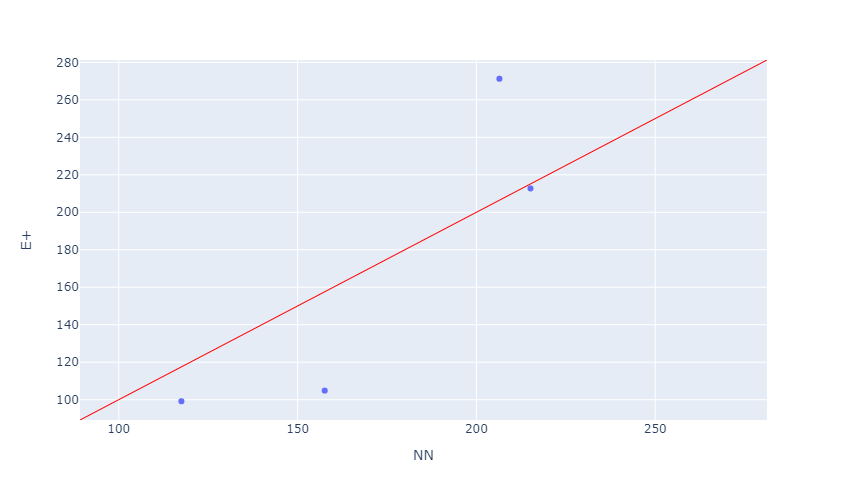

In [40]:
#Scatter subplots of NN vs E+ results

#for now we will do it quickly with express
import plotly.express as px


# traces=[]

# traces.append(
#     go.Scatter(x=test_eval_df['Heating:Gas'],
#               y=test_in['Heating:Gas']))

variable='TEU'
min_range=test_out[variable].min()-10
max_range=test_out[variable].max()+10

fig = px.scatter(x=test_eval_df[variable],y=test_out[variable])
fig.update_layout(
        yaxis=dict(range=[min_range,max_range]),
        xaxis=dict(range=[min_range,max_range]),
        xaxis_title='NN',
        yaxis_title='E+',
        height=500,
        width=500)

fig.add_shape(
        # 1-1 Line
        dict(
            type="line",
            x0=min_range,
            y0=min_range,
            x1=max_range,
            y1=max_range,
            line=dict(
                color="Red",
                width=1
            )))
fig.show()

In [41]:
# #Scatter subplots of NN vs E+ results

# #for now we will do it quickly with express
# import plotly.express as px


# # traces=[]

# # traces.append(
# #     go.Scatter(x=test_eval_df['Heating:Gas'],
# #               y=test_in['Heating:Gas']))

# variable='Cooling:Electricity'
# min_range=test_out[variable].min()-10
# max_range=test_out[variable].max()+10

# fig = px.scatter(x=test_eval_df[variable],y=test_out[variable])
# fig.update_layout(
#         yaxis=dict(range=[min_range,max_range]),
#         xaxis=dict(range=[min_range,max_range]),
#         xaxis_title='NN',
#         yaxis_title='E+',
#         height=500,
#         width=500)

# fig.add_shape(
#         # 1-1 Line
#         dict(
#             type="line",
#             x0=min_range,
#             y0=min_range,
#             x1=max_range,
#             y1=max_range,
#             line=dict(
#                 color="Red",
#                 width=1
#             )))
# fig.show()

# Store metadata

In [42]:
results_EUI.columns=['Electricity:Facility [ekWh/m2]', 'DistrictHeating:Facility [ekWh/m2]',
       'DistrictCooling:Facility [ekWh/m2]', 'Heating:DistrictHeating [ekWh/m2]',
       'Cooling:DistrictCooling [ekWh/m2]', 'InteriorLights:Electricity [ekWh/m2]',
       'InteriorEquipment:Electricity [ekWh/m2]', 'TEU [ekWh/m2]']

In [43]:
inputs_dataframe = inputs_onehot
inputs_index = inputs_onehot.columns
outputs_dataframe = results_EUI
outputs_index = results_EUI.columns
inputs_scaler = scaler_in
outputs_scaler = scaler_out

In [44]:
all_model_metadata = {"inputs_index": inputs_index,
                      "inputs_metadata": inputs_metadata,
                      "model_attributes": model_attributes,
                      "outputs_index": outputs_index,
                      "outputs_metadata": outputs_metadata,
                      "inputs_scaler": inputs_scaler,
                      "outputs_scaler": outputs_scaler,
                      "inputs_dataframe": inputs_dataframe,
                      "outputs_dataframe": outputs_dataframe}

In [45]:
import pickle
pickle.dump(all_model_metadata, open('model_pickle','wb'))

# Store model

In [46]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Tensorflow js model

In [47]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,'model_new')

/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning:

The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.



In [48]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)